In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import glob
import math
import itertools
import numpy as np
import sklearn.metrics as metrics

import tensorflow as tf
from keras.models import Sequential
from keras.initializers import Constant, TruncatedNormal
from keras.layers import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D, Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, Callback

Using TensorFlow backend.


In [2]:
train_features, train_labels = np.load('./datasets/data_allcuts/train_features.npy'), np.load('./datasets/data_allcuts/train_labels.npy')
test_features, test_labels = np.load('./datasets/data_allcuts/test_features.npy'), np.load('./datasets/data_allcuts/test_labels.npy')
num_classes = 4
cost_history = np.empty(shape=[1],dtype=float)

In [3]:
class EvaluateValidation(Callback):      
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        global cost_history
        cost_history = np.append(cost_history,loss)
        print('\nValidation loss: {}, acc: {}\n'.format(loss, acc),'Metric Names: ', self.model.metrics_names)

In [4]:
def build_model():
    k_init_1 = TruncatedNormal(mean=0.0, stddev=math.sqrt(2.0/1800), seed=None)
    k_init_2 = TruncatedNormal(mean=0.0, stddev=math.sqrt(2.0/28800), seed=None)
    k_init_3 = TruncatedNormal(mean=0.0, stddev=math.sqrt(2.0/40320), seed=None)
    k_init_4 = TruncatedNormal(mean=0.0, stddev=math.sqrt(2.0/200), seed=None)

    bias_init = Constant(value=0.1)
    adam = Adam(lr=1e-3, decay=0.75)
    
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(30, 30), strides=(1,1), padding='same',
                            data_format='channels_last', kernel_initializer=k_init_1, bias_initializer=bias_init,
                            input_shape=(60, 41, 2)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Convolution2D(filters=64, kernel_size=(30, 30), strides=(1,1), padding='same',
                            data_format='channels_last', kernel_initializer=k_init_2, bias_initializer=bias_init))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2),padding='valid'))
    
    model.add(Flatten())
    model.add(Dense(200, kernel_initializer=k_init_3, bias_initializer=bias_init))
    model.add(Activation('relu'))
    
    model.add(Dense(num_classes, kernel_initializer=k_init_4, bias_initializer=bias_init))
    model.add(Activation('softmax'))
    
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
model = build_model()
model.summary()

from keras.backend import get_session
get_session().run(tf.global_variables_initializer())
a = model.fit(train_features, train_labels, batch_size=50, epochs=200, verbose=1, callbacks=[EvaluateValidation((test_features, test_labels))])

loss_and_metrics = model.evaluate(test_features, test_labels, batch_size=50, verbose=1)
y_pred = model.predict(test_features, batch_size=50, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 41, 32)        57632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 41, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 60, 41, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 41, 64)        1843264   
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 41, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 60, 41, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 20, 64)        0         
__________

In [6]:
print "Loss and accuracy: ", loss_and_metrics

Loss and accuracy:  [10.848005074721117, 0.061538460162969738]


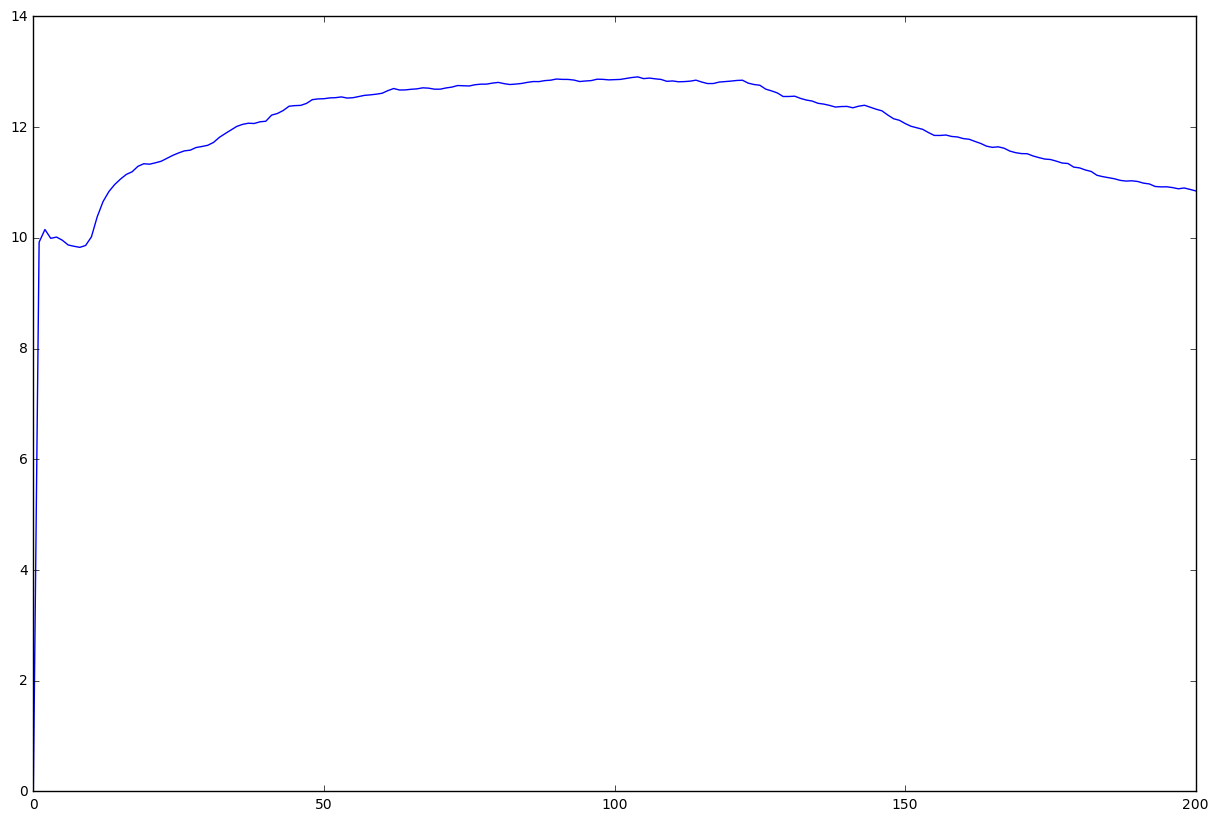

In [7]:
fig = plt.figure(figsize=(15,10))
plt.plot(cost_history)
# plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

In [9]:
y_test_class = np.argmax(test_labels, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)
conf_mat = metrics.confusion_matrix(y_test_class, y_pred_class)

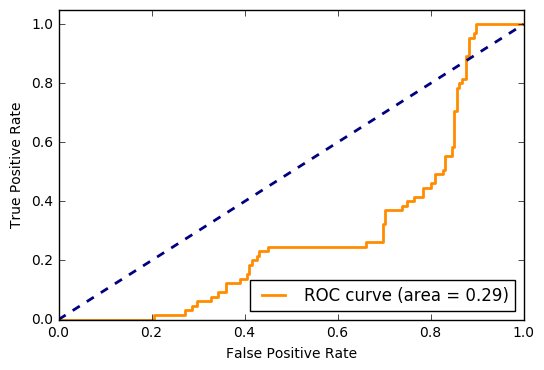

ROC AUC Score:  0.382900670617


In [11]:
# Compute ROC curve and ROC area for each class
n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_labels[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(test_labels.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

roc_score = metrics.roc_auc_score(test_labels, y_pred)

#print "Loss: {} Accuracy: {}%".format(loss_and_metrics[0],loss_and_metrics[1] * 100)
print "ROC AUC Score: ", roc_score

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 2  6  7  0]
 [ 0  0  9 15]
 [ 0 20  0  0]
 [ 1  1  2  2]]


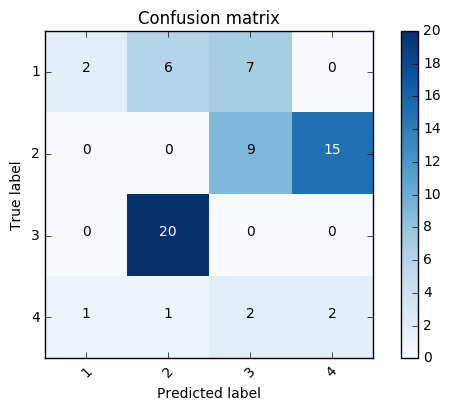

In [14]:
plot_confusion_matrix(conf_mat, classes=['1', '2', '3', '4'])